In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import csv
import pandas as pd
print(tf.__version__)

1.10.0


In [2]:
# LOAD DATA
x_train = np.load("train_x.npy")
arousal_y_train = np.load("arousal_train_y.npy")
x_test = np.load("test_x.npy")
arousal_y_test = np.load("arousal_test_y.npy")

arousal_y_train = arousal_y_train.flatten()
arousal_y_test = arousal_y_test.flatten()

# Shuffle the training set
order = np.argsort(np.random.random(arousal_y_train.shape))
x_train = x_train[order]
arousal_y_train = arousal_y_train[order]

print("training set: {}".format(x_train.shape))
print("arousal_y_train: {}".format(arousal_y_train.shape))
print("testing set: {}".format(x_test.shape))
print("arousal_y_test: {}".format(arousal_y_test.shape))

training set: (1351, 193)
arousal_y_train: (1351,)
testing set: (451, 193)
arousal_y_test: (451,)


In [3]:
# Normalize the data

print(x_train[0][1], type(x_train[0][1]))  # Display sample features, notice the different scales

# Using mean and standard deviation
# mean = x_train.mean(axis=0)
# std = x_train.std(axis=0)
# x_train = (x_train - mean) / std
# x_test = (x_test - mean) / std

# Using keras utilities normalize
x_train = tf.keras.utils.normalize(x_train, axis=1)  # scales data between 0 and 1
x_test = tf.keras.utils.normalize(x_test, axis=1)  # scales data between 0 and 1

print(x_train[0][1], type(x_train[0][1]))


100.21057422896567 <class 'numpy.float64'>
0.5078244170835978 <class 'numpy.float64'>


In [4]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(x_train, arousal_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [6]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Arousal]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

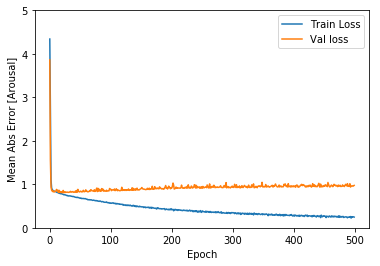

In [7]:
plot_history(history)


.....................................

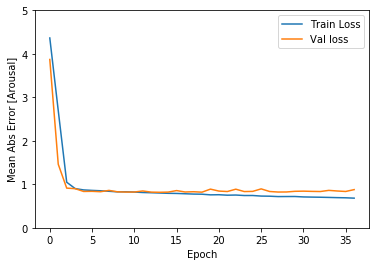

In [8]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, arousal_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [9]:
[loss, mae] = model.evaluate(x_test, arousal_y_test, verbose=0)

print("Testing set Mean Abs Error:{:7.2f}".format(mae))

Testing set Mean Abs Error:   0.75


In [10]:
test_predictions = model.predict(x_test).flatten()

print(len(test_predictions))
print(len(arousal_y_test))

451
451


In [11]:
less_than_one=0
less_than_two=0
less_than_three=0
not_manageable=0

for i in range(len(arousal_y_test)):
    diff = abs(test_predictions[i] - arousal_y_test[i])
    if(diff < 1):
        less_than_one = less_than_one + 1
    elif(diff < 2):
        less_than_two = less_than_two + 1
    elif(diff < 3):
        less_than_three = less_than_three + 1
    else:
        not_manageable = not_manageable + 1
    print("test[{0:}] - expected: {1:.1f}, prediction: {2:.1f}".format(i,test_predictions[i],arousal_y_test[i]))
print("Differences\nLess than one: {}\nLess than two: {}\nLess than three: {}".format(less_than_one,less_than_two,less_than_three))

# print("test[{}] - values different by {:.1f}".format(i,diff))
# print("test[436] - expected: {0:.1f}, prediction: {1:.1f}".format(test_predictions[436],arousal_y_test[436]))

test[0] - expected: 6.4, prediction: 7.0
test[1] - expected: 6.1, prediction: 6.5
test[2] - expected: 3.7, prediction: 4.1
test[3] - expected: 5.3, prediction: 6.2
test[4] - expected: 4.1, prediction: 3.1
test[5] - expected: 5.4, prediction: 6.6
test[6] - expected: 4.2, prediction: 4.6
test[7] - expected: 4.5, prediction: 4.6
test[8] - expected: 5.6, prediction: 5.5
test[9] - expected: 4.8, prediction: 5.9
test[10] - expected: 5.6, prediction: 3.9
test[11] - expected: 6.2, prediction: 5.3
test[12] - expected: 5.9, prediction: 5.7
test[13] - expected: 4.8, prediction: 6.0
test[14] - expected: 4.7, prediction: 5.9
test[15] - expected: 5.1, prediction: 5.3
test[16] - expected: 5.1, prediction: 6.4
test[17] - expected: 4.6, prediction: 4.4
test[18] - expected: 6.2, prediction: 6.0
test[19] - expected: 4.6, prediction: 3.9
test[20] - expected: 4.6, prediction: 4.8
test[21] - expected: 4.5, prediction: 6.3
test[22] - expected: 4.7, prediction: 5.4
test[23] - expected: 5.0, prediction: 4.8
te

In [12]:
less_than_one+less_than_two+less_than_three

451